# EDSR

In [1]:
import os
import matplotlib.pyplot as plt

from model.common import psnr
from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer
from tensorflow.keras.layers import BatchNormalization

import tensorflow as tf
import numpy as np
%matplotlib inline

In [2]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [6]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [ ]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

In [ ]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [ ]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

In [ ]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [6]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [27]:
from model import resolve_single
from utils import load_image, plot_sample
from matplotlib import pyplot as plt
def resolve_and_plot(lr_image_path, op_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plt.imshow(sr)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('op_path')
    plot_sample(lr,sr) 
    #return tf.image.psnr(tf.image.resize(sr,[118,124]),lr,max_val=255)
    return tf.image.psnr(tf.image.resize(sr,[124,118]),lr,max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=7.2139854>

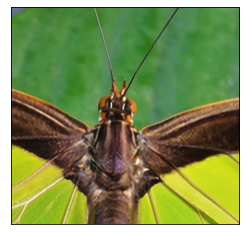

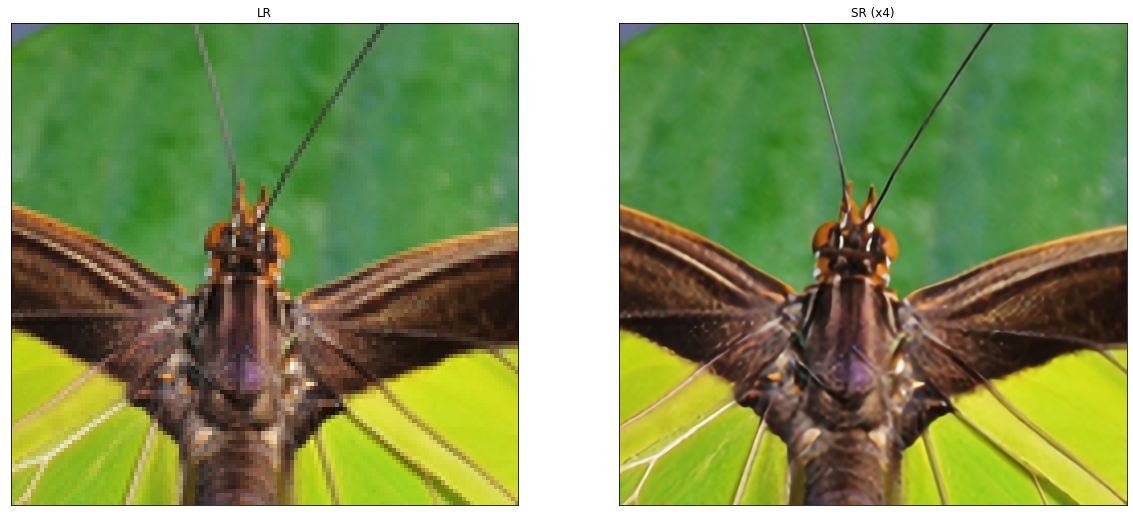

In [21]:
resolve_and_plot('demo/0829x4-crop.png', 'op1.png')

<tf.Tensor: shape=(), dtype=float32, numpy=9.9496>

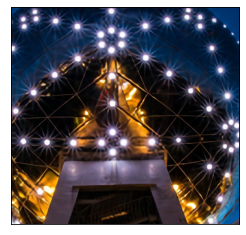

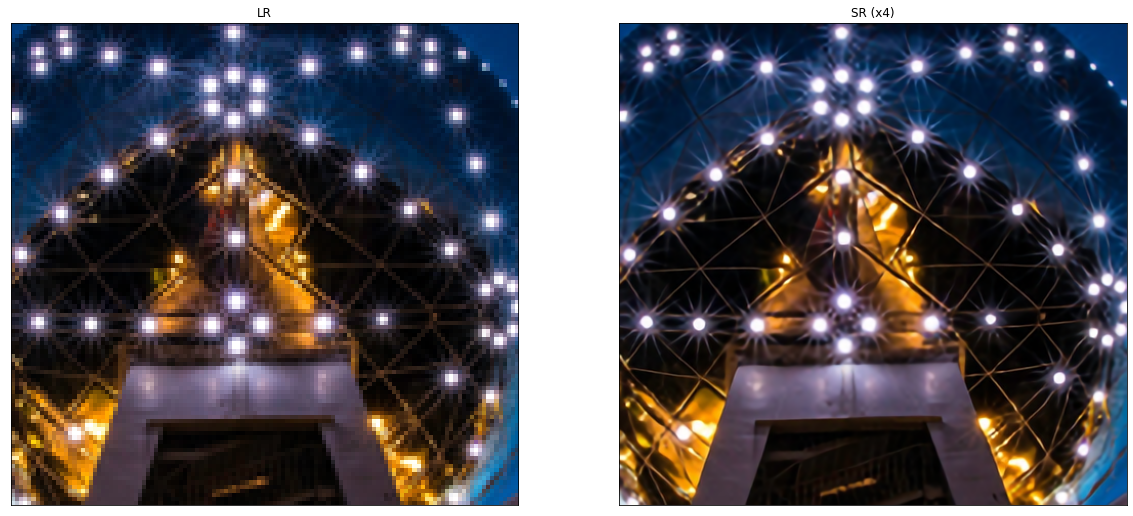

In [23]:
resolve_and_plot('demo/0851x4-crop.png','outputs/op2.png')

<tf.Tensor: shape=(), dtype=float32, numpy=5.1907578>

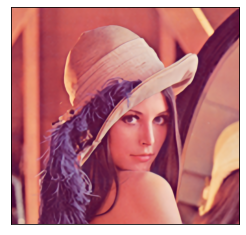

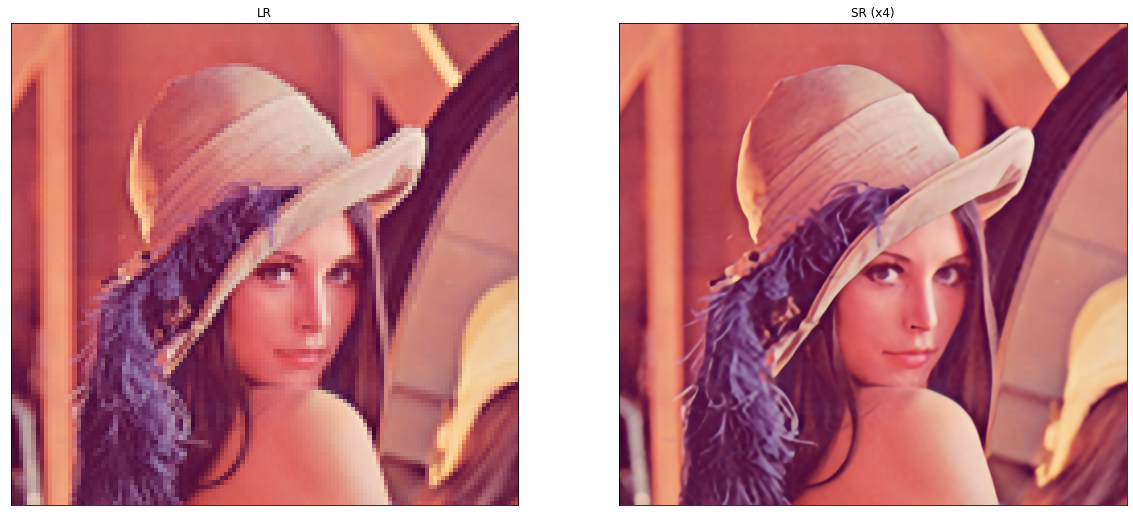

In [25]:
resolve_and_plot('demo/lena_r.png','outputs/op_lena.png')

<tf.Tensor: shape=(), dtype=float32, numpy=5.183178>

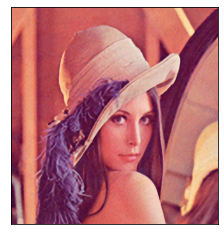

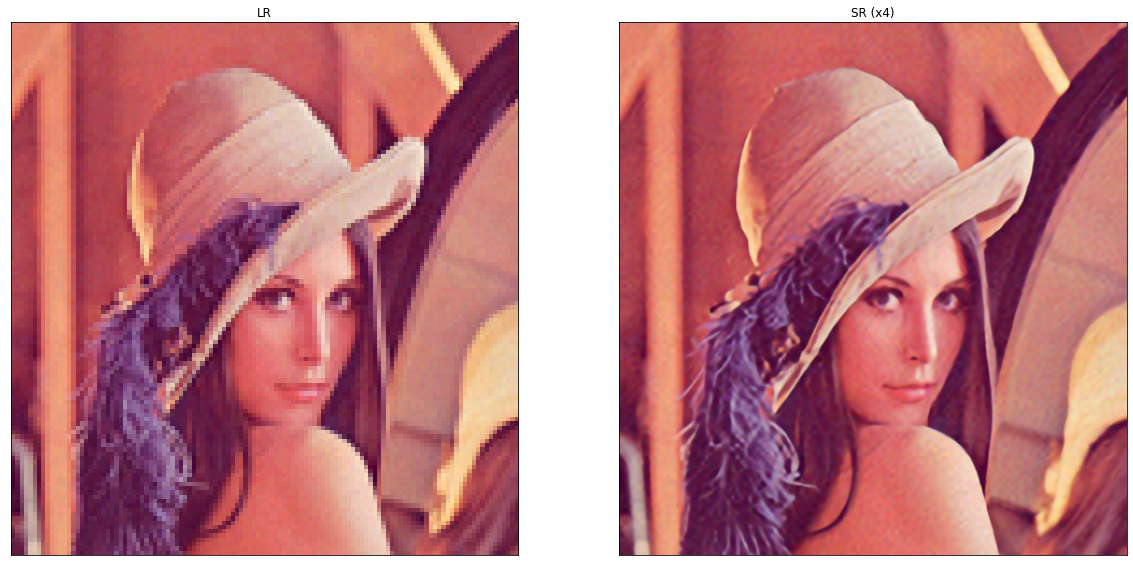

In [28]:
resolve_and_plot('demo/lena_encoded.png','outputs/op_lena_encoded.png')